# Laplace spectra of biological data

In this notebook we will use the Laplace spectra to analyze the biological data. We will use the same data as in the previous notebook. This notebook has been used in producing the figures for [this talk](https://f1000research.com/slides/12-1058).

In [ ]:
from skimage import data, morphology
import napari
import napari_shape_odyssey as nso
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_process_points_and_surfaces as nppas
from napari_threedee.visualization.lighting_control import LightingControl

import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
import tqdm
import os
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
viewer = napari.Viewer(ndisplay=3)

Invalid schema for package 'napari-stl-exporter', please run 'npe2 validate napari-stl-exporter' to check for manifest errors.


## Segmentation

In [ ]:
image = data.cells3d()
nuclei = image[:, 1]
membranes = image[:, 0]

segmentation = nsbatwm.voronoi_otsu_labeling(nuclei, 10, 2)
segmentation = np.asarray(cle.dilate_labels(segmentation, None, radius=1))
segmentation = morphology.area_closing(segmentation, 100, connectivity=1)

In [22]:
viewer.add_image(nuclei, name='nuclei', colormap='bop blue', blending='additive')
viewer.add_image(membranes, name='membranes', colormap='bop orange', blending='additive')
viewer.add_labels(segmentation, name='segmentation', opacity=0.5)

<Labels layer 'segmentation' at 0x1f1380cf370>

## Converting labels to surfaces

In [ ]:
label_1 = 23
label_2 = 2
label_3 = 14
label_4 = 18

In [24]:
surface_1 = nppas.label_to_surface(segmentation, label_1)
surface_2 = nppas.label_to_surface(segmentation, label_2)
surface_3 = nppas.label_to_surface(segmentation, label_3)
surface_4 = nppas.label_to_surface(segmentation, label_4)

surface_1_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface_1))
surface_2_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface_2))
surface_3_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface_3))
surface_4_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface_4))

viewer.add_surface(surface_1_smooth, name='surface_1', opacity=0.5)
viewer.add_surface(surface_2_smooth, name='surface_2', opacity=0.5)
viewer.add_surface(surface_3_smooth, name='surface_3', opacity=0.5)
viewer.add_surface(surface_4_smooth, name='surface_4', opacity=0.5)

<Surface layer 'surface_4 [1]' at 0x1f1214e38b0>

## Calculating spectra

In [25]:
eigenvectors_label_1, eigenvalues_label_1 = nso.spectral.shape_fingerprint(surface_1_smooth, 100)
eigenvectors_label_2, eigenvalues_label_2 = nso.spectral.shape_fingerprint(surface_2_smooth, 100)
eigenvectors_label_3, eigenvalues_label_3 = nso.spectral.shape_fingerprint(surface_3_smooth, 100)
eigenvectors_label_4, eigenvalues_label_4 = nso.spectral.shape_fingerprint(surface_4_smooth, 100)

In [26]:
mpl.style.use("default")
widget = LightingControl(viewer)

We now visualize the first `max_index` eigenvalues of the Laplace spectra of the surfaces and create a nice gif out of it:

In [ ]:
os.makedirs('./images', exist_ok=True)
max_index = 70

screenshots_label1 = []
screenshots_label2 = []
screenshots_label3 = []

for idx in tqdm.tqdm(range(max_index)):
    if idx == 0:
        continue

    # Label 1
    viewer.camera.center = (30, 84, 50)
    viewer.camera.angles = (4, -30, 83)
    viewer.camera.zoom = 13

    surface_to_visualize = (surface_1_smooth[0], surface_1_smooth[1], eigenvectors_label_1[:, idx])
    layer_visualize = viewer.add_surface(surface_to_visualize, name=f'Eigenvalue {idx}', opacity=1, colormap='inferno')
    widget.set_layers(layer_visualize)
    widget._on_enable()
    screenshot_label1 = viewer.screenshot()
    layer_visualize.visible = False

    # Label 2
    viewer.camera.center = (-34, 200, 143)
    viewer.camera.angles = (4, -30, 83)
    viewer.camera.zoom = 12

    surface_to_visualize = (surface_2_smooth[0], surface_2_smooth[1], eigenvectors_label_2[:, idx])
    layer_visualize = viewer.add_surface(surface_to_visualize, name=f'Eigenvalue {idx}', opacity=1, colormap='inferno')
    widget.set_layers(layer_visualize)
    widget._on_enable()
    screenshot_label2 = viewer.screenshot()
    layer_visualize.visible = False

    # Label 3
    viewer.camera.center = (33, 172, 101)
    viewer.camera.angles = (-19, 36, -13)
    viewer.camera.zoom = 11

    surface_to_visualize = (surface_3_smooth[0], surface_3_smooth[1], eigenvectors_label_3[:, idx])
    layer_visualize = viewer.add_surface(surface_to_visualize, name=f'Eigenvalue {idx}', opacity=1, colormap='inferno')
    widget.set_layers(layer_visualize)
    widget._on_enable()
    screenshot_label3 = viewer.screenshot()
    layer_visualize.visible = False

    screenshots_label1.append(screenshot_label1)
    screenshots_label2.append(screenshot_label2)
    screenshots_label3.append(screenshot_label3)

## Create a gif

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
img1 = axes[0, 0].imshow(screenshots_label1[0])
axes[0, 0].set_title('Label 1', fontsize=20, color='orange')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

img2 = axes[1, 0].imshow(screenshots_label2[0])
axes[1, 0].set_title('Label 2', fontsize=20, color='blue')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

img3 = axes[1, 1].imshow(screenshots_label3[0])
axes[1, 1].set_title('Label 3', fontsize=20, color='green')
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

line_eigenvalues_1 = axes[0,1].plot(eigenvalues_label_1[:1], 'orange', marker='o', label='Label 1')[0]
line_eigenvalues_2 = axes[0,1].plot(eigenvalues_label_2[:1], 'blue', marker='o', label='Label 2')[0]
line_eigenvalues_3 = axes[0,1].plot(eigenvalues_label_3[:1], 'green', marker='o', label='Label 3')[0]
# axes[1,1].plot(eigenvalues_label_4[:idx], 'red', marker='o', label='Label 4')

axes[0,1].legend(loc='upper left', fontsize=15)
axes[0,1].set_xlim(0, max_index)
axes[0,1].set_ylim(0, eigenvalues_label_1[max_index])
axes[0,1].set_title('Eigenvalues', fontsize=20)
axes[0,1].set_xlabel('Index')

# make background of all subplots white and 
for ax in axes.flatten():
    ax.set_facecolor('white')

fig.tight_layout()

def update(frame):
    img1.set_data(screenshots_label1[frame])
    img2.set_data(screenshots_label2[frame])
    img3.set_data(screenshots_label3[frame])
    line_eigenvalues_1.set_data(np.arange(frame), eigenvalues_label_1[:frame])
    line_eigenvalues_2.set_data(np.arange(frame), eigenvalues_label_2[:frame])
    line_eigenvalues_3.set_data(np.arange(frame), eigenvalues_label_3[:frame])
    return (img1, img2, img3, line_eigenvalues_1, line_eigenvalues_2, line_eigenvalues_3)

anim = animation.FuncAnimation(fig, update, frames=max_index-1, interval=100)
anim.save(filename="./images/eigenvalues.gif", writer="pillow", dpi=300)

Calculate difference of shape between some selected objects:

In [ ]:
# L2 norm of differences of eigenvalues
difference_label_12 = np.linalg.norm(eigenvalues_label_1 - eigenvalues_label_2)
difference_label_13 = np.linalg.norm(eigenvalues_label_1 - eigenvalues_label_3)
difference_label_23 = np.linalg.norm(eigenvalues_label_2 - eigenvalues_label_3)

# put in 3x3 array
difference_array = np.array([[0, difference_label_12, difference_label_13],
                                [difference_label_12, 0, difference_label_23],
                                [difference_label_13, difference_label_23, 0]])

# plot heatmap
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(difference_array, cmap='inferno')


## Dimensionality reduction

In [ ]:
eigenvals = []

for i in range(1, segmentation.max()+1):
    surface = nppas.label_to_surface(segmentation, i)
    surface_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface))

    eigenvectors, eigenvalues = nso.spectral.shape_fingerprint(surface_smooth, 100)

    # normalize by slope
    slope = np.polyfit(np.arange(len(eigenvalues)), eigenvalues, 1)[0]
    eigenvalues = eigenvalues / slope

    eigenvals.append(eigenvalues)

eigenvals = np.stack(eigenvals)

In [28]:
reducer = PCA(n_components=2)
reduced = reducer.fit_transform(eigenvals)

df = pd.DataFrame(reduced, columns=['PC1', 'PC2'])
df['label'] = np.arange(1, segmentation.max()+1)
viewer.layers['segmentation'].features = df

In [29]:
reducer.explained_variance_ratio_

array([0.87631582, 0.03203801])

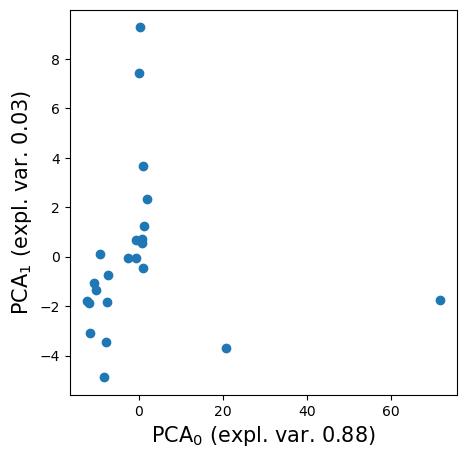

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342
Selected column PC2
Selected column PC1


In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(reduced[:, 0], reduced[:, 1], cmap='inferno')
ax.set_xlabel('PCA$_0$ (expl. var. {:.2f})'.format(reducer.explained_variance_ratio_[0]), fontsize=15)
ax.set_ylabel('PCA$_1$ (expl. var. {:.2f})'.format(reducer.explained_variance_ratio_[1]), fontsize=15)

fig.savefig('./images/PCA.png', dpi=300, bbox_inches='tight', pad_inches=0)